In [1]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#!pip uninstall q keras


Uninstalling Keras-2.2.5:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.2.5.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.2.5


In [3]:
!pip install q keras==2.2.4

import keras
print(keras.__version__)

     |████████████████████████████████| 317kB 4.9MB/s 


Using TensorFlow backend.


2.2.4


In [4]:
!ls "/content/drive/My Drive/yolo"

beach.jpg	     horses.jpg		  person.jpg	voc_classes.txt
dog.jpg		     model.py		  selfie.jpg	yolo_anchors.txt
ellen.jpg	     outputs		  two_dogs.jpg	yolov3.cfg
FiraMono-Medium.otf  output_two_dogs.png  utils.py


In [0]:
!cp -R "/content/drive/My Drive/yolo" "/content/"
!cp "/content/drive/My Drive/yolo/dog.jpg" "yolo/dog.jpg"
!cp "/content/drive/My Drive/yolo/horses.jpg" "yolo/horses.jpg"
!cp "/content/drive/My Drive/yolo/person.jpg" "yolo/person.jpg"
!cp "/content/drive/My Drive/yolo/ellen.jpg" "yolo/ellen.jpg"
!cp "/content/drive/My Drive/yolo/selfie.jpg" "yolo/selfie.jpg"
!cp "/content/drive/My Drive/yolo/beach.jpg" "yolo/beach.jpg"
!cp "/content/drive/My Drive/yolo/two_dogs.jpg" "yolo/two_dogs.jpg"

## Data preprocessing

We will be looking at the [Pascal VOC dataset]


In [6]:
!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
#!wget https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
!tar xf VOCtrainval_06-Nov-2007.tar
#!tar xf VOCtest_06-Nov-2007.tar

--2019-11-02 13:46:05--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  68.5MB/s    in 6.8s    

2019-11-02 13:46:12 (64.2 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



As well as the images, there are also annotations - bounding boxes showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so I use the more recent JSON version.


In [7]:
! wget 'https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip'
! unzip 'PASCAL_VOC.zip'

--2019-11-02 13:46:20--  https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1998182 (1.9M) [application/zip]
Saving to: ‘PASCAL_VOC.zip’

PASCAL_VOC.zip      100%[===================>]   1.91M  --.-KB/s    in 0.02s   

2019-11-02 13:46:20 (108 MB/s) - ‘PASCAL_VOC.zip’ saved [1998182/1998182]

Archive:  PASCAL_VOC.zip
   creating: PASCAL_VOC/
  inflating: PASCAL_VOC/pascal_test2007.json  
  inflating: PASCAL_VOC/pascal_train2007.json  
  inflating: PASCAL_VOC/pascal_train2012.json  
  inflating: PASCAL_VOC/pascal_val2007.json  
  inflating: PASCAL_VOC/pascal_val2012.json  


### YOLO v3 preprocessing

In [8]:
from pathlib import Path
path = Path('yolo')

! wget 'https://pjreddie.com/media/files/yolov3.weights' -P {path}

--2019-11-02 13:46:44--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolo/yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  65.0MB/s    in 3.9s    

2019-11-02 13:46:48 (60.3 MB/s) - ‘yolo/yolov3.weights’ saved [248007048/248007048]



In [9]:
#! /usr/bin/env python
"""
Reads Darknet config and weights and creates Keras model with TF backend.

"""
import configparser
import io
import os
from collections import defaultdict

import numpy as np
from keras import backend as K
from keras.layers import (Conv2D, Input, ZeroPadding2D, Add,
                          UpSampling2D, MaxPooling2D, Concatenate)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model as plot


config_path = path/'yolov3.cfg'
weights_path = path/'yolov3.weights'
output_path = path/'yolov3.h5'

def unique_config_sections(config_file):
    """Convert all config sections to have unique names.

    Adds unique suffixes to config sections for compability with configparser.
    """
    section_counters = defaultdict(int)
    output_stream = io.StringIO()
    with open(config_file) as fin:
        for line in fin:
            if line.startswith('['):
                section = line.strip().strip('[]')
                _section = section + '_' + str(section_counters[section])
                section_counters[section] += 1
                line = line.replace(section, _section)
            output_stream.write(line)
    output_stream.seek(0)
    return output_stream

config_path = os.path.expanduser(config_path)
weights_path = os.path.expanduser(weights_path)
assert config_path.endswith('.cfg'), '{} is not a .cfg file'.format(
    config_path)
assert weights_path.endswith(
    '.weights'), '{} is not a .weights file'.format(weights_path)

output_path = os.path.expanduser(output_path)
assert output_path.endswith(
    '.h5'), 'output path {} is not a .h5 file'.format(output_path)
output_root = os.path.splitext(output_path)[0]

# Load weights and config.
print('Loading weights.')
weights_file = open(weights_path, 'rb')
major, minor, revision = np.ndarray(
    shape=(3, ), dtype='int32', buffer=weights_file.read(12))
if (major*10+minor)>=2 and major<1000 and minor<1000:
    seen = np.ndarray(shape=(1,), dtype='int64', buffer=weights_file.read(8))
else:
    seen = np.ndarray(shape=(1,), dtype='int32', buffer=weights_file.read(4))
print('Weights Header: ', major, minor, revision, seen)

print('Parsing Darknet config.')
unique_config_file = unique_config_sections(config_path)
cfg_parser = configparser.ConfigParser()
cfg_parser.read_file(unique_config_file)

print('Creating Keras model.')
input_layer = Input(shape=(None, None, 3))
prev_layer = input_layer
all_layers = []

weight_decay = float(cfg_parser['net_0']['decay']
                     ) if 'net_0' in cfg_parser.sections() else 5e-4
count = 0
out_index = []
for section in cfg_parser.sections():
    print('Parsing section {}'.format(section))
    if section.startswith('convolutional'):
        filters = int(cfg_parser[section]['filters'])
        size = int(cfg_parser[section]['size'])
        stride = int(cfg_parser[section]['stride'])
        pad = int(cfg_parser[section]['pad'])
        activation = cfg_parser[section]['activation']
        batch_normalize = 'batch_normalize' in cfg_parser[section]

        padding = 'same' if pad == 1 and stride == 1 else 'valid'

        # Setting weights.
        # Darknet serializes convolutional weights as:
        # [bias/beta, [gamma, mean, variance], conv_weights]
        prev_layer_shape = K.int_shape(prev_layer)

        weights_shape = (size, size, prev_layer_shape[-1], filters)
        darknet_w_shape = (filters, weights_shape[2], size, size)
        weights_size = np.product(weights_shape)

        print('conv2d', 'bn'
              if batch_normalize else '  ', activation, weights_shape)

        conv_bias = np.ndarray(
            shape=(filters, ),
            dtype='float32',
            buffer=weights_file.read(filters * 4))
        count += filters

        if batch_normalize:
            bn_weights = np.ndarray(
                shape=(3, filters),
                dtype='float32',
                buffer=weights_file.read(filters * 12))
            count += 3 * filters

            bn_weight_list = [
                bn_weights[0],  # scale gamma
                conv_bias,  # shift beta
                bn_weights[1],  # running mean
                bn_weights[2]  # running var
            ]

        conv_weights = np.ndarray(
            shape=darknet_w_shape,
            dtype='float32',
            buffer=weights_file.read(weights_size * 4))
        count += weights_size

        # DarkNet conv_weights are serialized Caffe-style:
        # (out_dim, in_dim, height, width)
        # We would like to set these to Tensorflow order:
        # (height, width, in_dim, out_dim)
        conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])
        conv_weights = [conv_weights] if batch_normalize else [
            conv_weights, conv_bias
        ]

        # Handle activation.
        act_fn = None
        if activation == 'leaky':
            pass  # Add advanced activation later.
        elif activation != 'linear':
            raise ValueError(
                'Unknown activation function `{}` in section {}'.format(
                    activation, section))

        # Create Conv2D layer
        if stride>1:
            # Darknet uses left and top padding instead of 'same' mode
            prev_layer = ZeroPadding2D(((1,0),(1,0)))(prev_layer)
        conv_layer = (Conv2D(
            filters, (size, size),
            strides=(stride, stride),
            kernel_regularizer=l2(weight_decay),
            use_bias=not batch_normalize,
            weights=conv_weights,
            activation=act_fn,
            padding=padding))(prev_layer)

        if batch_normalize:
            conv_layer = (BatchNormalization(
                weights=bn_weight_list))(conv_layer)
        prev_layer = conv_layer

        if activation == 'linear':
            all_layers.append(prev_layer)
        elif activation == 'leaky':
            act_layer = LeakyReLU(alpha=0.1)(prev_layer)
            prev_layer = act_layer
            all_layers.append(act_layer)

    elif section.startswith('route'):
        ids = [int(i) for i in cfg_parser[section]['layers'].split(',')]
        layers = [all_layers[i] for i in ids]
        if len(layers) > 1:
            print('Concatenating route layers:', layers)
            concatenate_layer = Concatenate()(layers)
            all_layers.append(concatenate_layer)
            prev_layer = concatenate_layer
        else:
            skip_layer = layers[0]  # only one layer to route
            all_layers.append(skip_layer)
            prev_layer = skip_layer

    elif section.startswith('maxpool'):
        size = int(cfg_parser[section]['size'])
        stride = int(cfg_parser[section]['stride'])
        all_layers.append(
            MaxPooling2D(
                pool_size=(size, size),
                strides=(stride, stride),
                padding='same')(prev_layer))
        prev_layer = all_layers[-1]

    elif section.startswith('shortcut'):
        index = int(cfg_parser[section]['from'])
        activation = cfg_parser[section]['activation']
        assert activation == 'linear', 'Only linear activation supported.'
        all_layers.append(Add()([all_layers[index], prev_layer]))
        prev_layer = all_layers[-1]

    elif section.startswith('upsample'):
        stride = int(cfg_parser[section]['stride'])
        assert stride == 2, 'Only stride=2 supported.'
        all_layers.append(UpSampling2D(stride)(prev_layer))
        prev_layer = all_layers[-1]

    elif section.startswith('yolo'):
        out_index.append(len(all_layers)-1)
        all_layers.append(None)
        prev_layer = all_layers[-1]

    elif section.startswith('net'):
        pass

    else:
        raise ValueError(
            'Unsupported section header type: {}'.format(section))

# Create and save model.
if len(out_index)==0: out_index.append(len(all_layers)-1)
model = Model(inputs=input_layer, outputs=[all_layers[i] for i in out_index])
print(model.summary())

# model.save_weights('{}'.format(output_path))
# print('Saved Keras weights to {}'.format(output_path))

model.save('{}'.format(output_path))
print('Saved Keras model to {}'.format(output_path))

# Check to see if all weights have been read.
remaining_weights = len(weights_file.read()) / 4
weights_file.close()
print('Read {} of {} from Darknet weights.'.format(count, count +
                                                   remaining_weights))
if remaining_weights > 0:
    print('Warning: {} unused weights'.format(remaining_weights))

Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.


Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)









Parsing section convolutional_1
conv2d bn leaky (3, 3, 32, 64)
Parsing section convolutional_2
conv2d bn leaky (1, 1, 64, 32)
Parsing section convolutional_3
conv2d bn leaky (3, 3, 32, 64)
Parsing section shortcut_0
Parsing section convolutional_4
conv2d bn leaky (3, 3, 64, 128)
Parsing section convolutional_5
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_6
conv2d bn leaky (3, 3, 64, 128)
Parsing section shortcut_1
Parsing section convolutional_7
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_8
conv2d bn leaky (3, 3, 64, 128)
Parsing section shortcut_2
Parsing section convolutional_9
conv2d bn leaky (3, 3, 128, 256)
Parsing section convolutional_10
conv2d bn leaky (1, 1, 256, 128)
Parsing section convolutional_11
conv2d bn leaky (3, 3, 128, 256)
Parsing section short

In [10]:
import xml.etree.ElementTree as ET
from os import getcwd

sets=[('2007', 'train'), ('2007', 'val')]

classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


def convert_annotation(year, image_id, list_file):
    in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

wd = getcwd()

for year, image_set in sets:
    image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
    list_file = open('%s_%s.txt'%(year, image_set), 'w')
    for image_id in image_ids:
        list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
        convert_annotation(year, image_id, list_file)
        list_file.write('\n')
    list_file.close()

os.system("cat 2007_train.txt 2007_val.txt > train.txt")

0

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pwd

/content


## YOLO V3



In [0]:
import numpy as np
import time
import keras.backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Lambda
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from PIL import Image
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

from yolo.model import preprocess_true_boxes, yolo_body, yolo_loss
from yolo.utils import get_random_data, draw_boxes, get_colors_for_classes

In [0]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [0]:
def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='yolo/yolov3.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

In [0]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

In [16]:
import keras
print(keras.__version__)




2.2.4


     |████████████████████████████████| 317kB 4.9MB/s 


### Training

In [17]:
annotation_path = '2007_train.txt'
log_dir = 'yolo/logs/'
classes_path = 'yolo/voc_classes.txt'
anchors_path = 'yolo/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416, 416)  # multiple of 32, hw

model = create_model(input_shape, anchors, num_classes,
                      freeze_body=2, weights_path='yolo/yolov3.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# # # Train with frozen layers first, to get a stable loss.
# # # Adjust num epochs to .This step is enough to obtain a not bad model.
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 32
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')
    


    model.save(log_dir + 'yolov3.h5')


Create YOLOv3 model with 9 anchors and 20 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 75) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 75) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights yolo/yolov3.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2251 samples, val on 250 samples, with batch size 32.




Epoch 1/50
70/70 [==============================] - 237s 3s/step - loss: 1264.6713 - val_loss: 166.2449

Epoch 2/50
70/70 [==============================] - 219s 3s/step - loss: 124.4175 - val_loss: 94.0770
Epoch 3/50
70/70 [==============================] - 217s 3s/step - loss: 80.7187 - val_loss: 66.9004
Epoch 4/50
70/70 [==============================] - 190s 3s/step - loss: 61.7643 - val_loss: 56.1316
Epoch 5/50
70/70 [==============================] - 220s 3s/step - loss: 51.9327 - val_loss: 46.4215
Epoch 6/50
70/70 [==============================] - 215s 3s/step - loss: 45.6517 - val_loss: 42.6393
Epoch 7/50
70/70 [==============================] - 221s 3s/step - loss: 41.4853 - val_loss: 38.4140
Epoch 8/50
70/70 [=============================

In [24]:
# # Unfreeze and continue training, to fine-tune.
# # Train longer if the result is not good.
if True:
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 10 # more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=10,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

#     #Further training if needed.
    model.save(log_dir + 'yolov3_retrained.h5')

Unfreeze all of the layers.
Train on 2251 samples, val on 250 samples, with batch size 10.
Epoch 1/10
225/225 [==============================] - 405s 2s/step - loss: 22.9543 - val_loss: 23.6410
Epoch 2/10
225/225 [==============================] - 379s 2s/step - loss: 22.2117 - val_loss: 22.3736
Epoch 3/10
225/225 [==============================] - 378s 2s/step - loss: 21.6206 - val_loss: 22.7778
Epoch 4/10
225/225 [==============================] - 378s 2s/step - loss: 21.4425 - val_loss: 22.2150
Epoch 5/10
225/225 [==============================] - 378s 2s/step - loss: 21.1050 - val_loss: 23.1817
Epoch 6/10
225/225 [==============================] - 378s 2s/step - loss: 20.8203 - val_loss: 23.1797
Epoch 7/10
225/225 [==============================] - 378s 2s/step - loss: 20.8179 - val_loss: 23.0131

Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 8/10
225/225 [==============================] - 378s 2s/step - loss: 19.7803 - val_loss: 22.1183
Epoc

### Inference

In [0]:
import tensorflow as tf
def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats[0]))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape):
    '''Get corrected boxes'''
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = K.cast(input_shape, K.dtype(box_yx))
    image_shape = K.cast(image_shape, K.dtype(box_yx))
    new_shape = K.round(image_shape * K.min(input_shape/image_shape))
    offset = (input_shape-new_shape)/2./input_shape
    scale = input_shape/new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes =  K.concatenate([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ])

    # Scale boxes back to original image shape.
    boxes *= K.concatenate([image_shape, image_shape])
    return boxes


def yolo_boxes_and_scores(feats, anchors, num_classes, input_shape, image_shape):
    '''Process Conv layer output'''
    box_xy, box_wh, box_confidence, box_class_probs = yolo_head(feats,
        anchors, num_classes, input_shape)
    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = K.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = K.reshape(box_scores, [-1, num_classes])
    return boxes, box_scores


def yolo_eval(yolo_outputs,
              anchors,
              num_classes,
              image_shape,
              max_boxes=20,
              score_threshold=.6,
              iou_threshold=.5):
    """Evaluate YOLO model on given input and return filtered boxes."""
    num_layers = len(yolo_outputs)
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]] # default setting
    input_shape = K.shape(yolo_outputs[0])[1:3] * 32
    boxes = []
    box_scores = []
    for l in range(num_layers):
        _boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[l],
            anchors[anchor_mask[l]], num_classes, input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = K.concatenate(boxes, axis=0)
    box_scores = K.concatenate(box_scores, axis=0)

    mask = box_scores >= score_threshold
    max_boxes_tensor = K.constant(max_boxes, dtype='int32')
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(num_classes):
        # TODO: use keras backend instead of tf.
        class_boxes = tf.boolean_mask(boxes, mask[:, c])
        class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])
        nms_index = tf.image.non_max_suppression(
            class_boxes, class_box_scores, max_boxes_tensor, iou_threshold=iou_threshold)
        class_boxes = K.gather(class_boxes, nms_index)
        class_box_scores = K.gather(class_box_scores, nms_index)
        classes = K.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)
    boxes_ = K.concatenate(boxes_, axis=0)
    scores_ = K.concatenate(scores_, axis=0)
    classes_ = K.concatenate(classes_, axis=0)

    return boxes_, scores_, classes_


In [0]:
sess = K.get_session()

classes_path = 'yolo/voc_classes.txt'
anchors_path = 'yolo/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)
input_shape=(416, 416)

In [0]:
yolo_model = yolo_body(Input(shape=(None, None, 3)), num_anchors//3, num_classes)
yolo_model.load_weights('yolo/logs/trained_weights_final.h5')

In [26]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_151 (Conv2D)             (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_145 (BatchN (None, None, None, 3 128         conv2d_151[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_145 (LeakyReLU)     (None, None, None, 3 0           batch_normalization_145[0][0]    
__________________________________________________________________________________________________
zero_paddi

In [0]:
def preprocess_image(image_path):    
    image = Image.open(image_path)
    new_image_size = (image.width - (image.width % 32),
                            image.height - (image.height % 32))
    resized_image = image.resize(new_image_size, Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')

    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) # Add batch dimension.

    return image_data, image

In [0]:
def predict(sess, image_path):
    
    start_time = time.time()
  
    image_data, image = preprocess_image(image_path)
    
    image_shape = image_data.shape[1:3]
    
    boxes, scores, classes = yolo_eval(yolo_model.output, anchors, num_classes, image_shape)

    out_boxes, out_scores, out_classes = sess.run([boxes, scores, classes], 
                                                  feed_dict={yolo_model.input:image_data,
                                                             K.learning_phase(): 0})
    print ("Time taken:", time.time()-start_time, "sec")
    print('Found {} boxes for {}'.format(len(out_boxes), image_path.split("/")[1]))
    
    colors = get_colors_for_classes(num_classes)

    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)

    output_path = "output_"+ str(image_path.split("/")[1])+ ".jpg"
    image.save(output_path, quality=90)

    output_image = Image.open(output_path)
    
    plt.grid(visible=False)
    plt.xticks([])
    plt.yticks([])
    imshow(output_image)

Time taken: 4.777302265167236 sec
Found 3 boxes for dog.jpg
bicycle 0.89 (160, 117) (587, 421)
car 0.98 (472, 90) (691, 172)
dog 0.99 (135, 222) (321, 523)


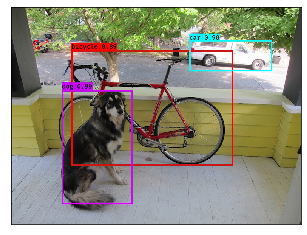

In [29]:
predict(sess, "yolo/dog.jpg")

Time taken: 5.806171417236328 sec
Found 9 boxes for ellen.jpg
person 1.00 (418, 46) (580, 315)
person 0.99 (1, 5) (161, 323)
person 0.99 (113, 93) (294, 323)
person 0.98 (190, 94) (550, 328)
person 0.85 (136, 8) (197, 103)
person 0.80 (398, 28) (448, 83)
person 0.79 (182, 12) (278, 105)
person 0.73 (315, 1) (426, 145)
person 0.64 (98, 84) (205, 321)


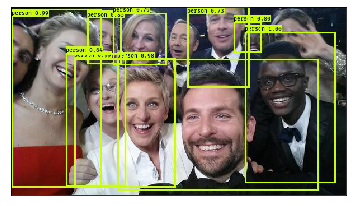

In [30]:
predict(sess, 'yolo/ellen.jpg')

Time taken: 12.796830654144287 sec
Found 20 boxes for selfie.jpg
person 1.00 (1018, 763) (1378, 1123)
person 1.00 (694, 714) (1063, 1108)
person 0.99 (1360, 690) (1675, 1129)
person 0.99 (518, 860) (654, 1091)
person 0.99 (3, 813) (167, 1116)
person 0.98 (1772, 663) (1898, 835)
person 0.98 (995, 768) (1099, 985)
person 0.97 (117, 888) (293, 1117)
person 0.96 (182, 499) (308, 625)
person 0.96 (1766, 841) (2040, 1115)
person 0.93 (596, 362) (641, 430)
person 0.92 (1945, 587) (2048, 904)
person 0.92 (147, 702) (280, 913)
person 0.90 (1566, 607) (1626, 697)
person 0.89 (1774, 496) (1816, 550)
person 0.89 (72, 412) (137, 477)
person 0.89 (186, 329) (246, 392)
person 0.88 (327, 848) (454, 1033)
person 0.88 (472, 1013) (636, 1124)
person 0.88 (250, 399) (303, 490)


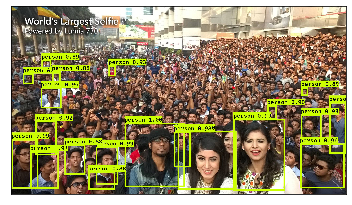

In [31]:
predict(sess, 'yolo/selfie.jpg')

Time taken: 7.005797863006592 sec
Found 2 boxes for horses.jpg
cow 0.98 (436, 217) (601, 346)
cow 0.98 (248, 190) (432, 354)


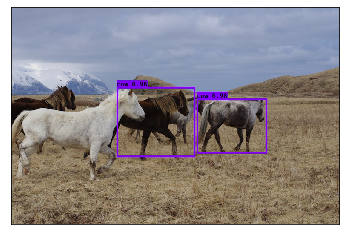

In [32]:
predict(sess, 'yolo/horses.jpg')

Time taken: 6.486537218093872 sec
Found 4 boxes for person.jpg
dog 0.97 (68, 259) (201, 346)
horse 0.76 (404, 136) (604, 388)
person 0.98 (195, 94) (273, 373)
sheep 0.83 (411, 124) (596, 315)


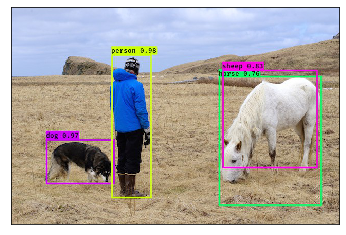

In [33]:
predict(sess, 'yolo/person.jpg')

Time taken: 8.147146463394165 sec
Found 2 boxes for two_dogs.jpg
dog 0.99 (15, 64) (323, 475)
dog 0.77 (576, 169) (994, 563)


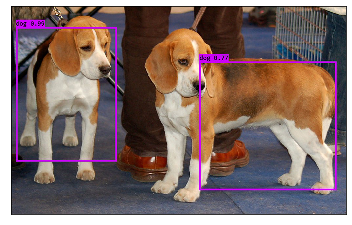

In [34]:
predict(sess, 'yolo/two_dogs.jpg')

Time taken: 9.930169582366943 sec
Found 5 boxes for beach.jpg
person 1.00 (116, 607) (162, 760)
person 0.99 (216, 697) (270, 850)
person 0.98 (82, 503) (105, 563)
person 0.86 (40, 511) (52, 555)
person 0.64 (21, 528) (39, 552)


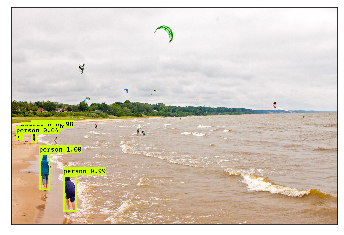

In [35]:
predict(sess, 'yolo/beach.jpg')